In [166]:
import torch
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torch.utils.data import random_split

import matplotlib.pyplot as plt

In [167]:
class LinearRegression(torch.nn.Module):
    def __init__(self, width, depth):
        super().__init__()

        self.input_l = torch.nn.Linear(2, width)
        self.hidden_l = torch.nn.ModuleList([torch.nn.Linear(width, width) for i in range(depth)])
        self.output_l = torch.nn.Linear(width, 1) # two hidden layer, Depth = 2
        self.act = torch.nn.ReLU()
    
    def forward(self, x):
        a = self.input_l(x)
        for linear in self.hidden_l:
            a = self.act(linear(a))
        return self.output_l(a)

linear_regression_model = LinearRegression(width = 10, depth = 10)
linear_regression_model

LinearRegression(
  (input_l): Linear(in_features=2, out_features=10, bias=True)
  (hidden_l): ModuleList(
    (0-9): 10 x Linear(in_features=10, out_features=10, bias=True)
  )
  (output_l): Linear(in_features=10, out_features=1, bias=True)
  (act): ReLU()
)

In [168]:
def noise(shape, low=-1.0, high=1.0):
    return (high - low) * torch.rand(shape) + low

def fn(x):
    # return np.sin(x) + noise(x.shape, low=0, high=1)
    # return np.sin(x) #+ noise(x.shape, low=0, high=1)
    # return x*10 #+ noise(x.shape, low=0, high=1)

    return torch.sin(x[:, 0].unsqueeze(1)) + torch.cos(x[:, 1].unsqueeze(1)) + noise(x.shape, low=0, high=1) # x[:, 0] are xs; x[:, 0] are the ys

class x_y_ds(Dataset):
    def __init__(self, fn, N):
        # self.xs = torch.linspace(min, max, N).unsqueeze(1)
        # self.ys = fn(self.xs)

        self.xs = torch.rand(N, 2)
        self.ys = fn(self.xs)

    def __len__(self):
        return len(self.ys)

    def __getitem__(self, idx):
        return self.xs[idx], self.ys[idx]
    
data = x_y_ds(fn, N = 100)
training_dataset, test_dataset = random_split(
    data, [80, 20]
)
    
train_dataloader = DataLoader(dataset = training_dataset, batch_size=10, shuffle=True)
test_dataloader = DataLoader(dataset = test_dataset, batch_size=10, shuffle=False)

In [169]:
widths = [1, 10, 20, 30]
depths = [1, 10, 20, 30]

logs = {}
nn_enum = 0
for w in widths:
    for d in depths:
        logs[f"NN{nn_enum}"] = {
                    "width": w,
                    "Depth": d,
                    "train_loss": [],
                    "test_loss": [],
                    "training_convergence_epoch": 1000,
                    "testing_convergence_epoch": 1000,
                    }
        nn_enum += 1

In [170]:
loss_fn = torch.nn.MSELoss()

epsilon_2 = 0.4
epsilon = 0.15
epochs = 1000
lr = 0.01

for NN, log in logs.items():
    old_train_loss = None
    old_test_loss = None
    is_training_converged = False
    is_testing_converged = False

    model = LinearRegression(width=log["width"], depth=log["Depth"])
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        epoch_loss_train= 0
        for x_batch, y_batch in train_dataloader:
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            epoch_loss_train+= loss.item()
            loss.backward()
            optimizer.step()
        
        epoch_loss_train /= len(train_dataloader)

        # checking convergence
        if old_train_loss is None:
            old_train_loss = epoch_loss_train
        else:
            if (abs(epoch_loss_train - old_train_loss) < epsilon_2) and (epoch_loss_train < epsilon) and (is_training_converged == False):
                 is_training_converged = True 
                 log["training_convergence_epoch"] = epoch
            old_train_loss = epoch_loss_train

        epoch_loss_test = 0
        with torch.no_grad():
            for x_batch_test, y_batch_test in test_dataloader:
                y_pred_test = model(x_batch_test)
                loss_test = loss_fn(y_pred_test, y_batch_test)
                epoch_loss_test += loss_test.item()
            epoch_loss_test /= len(test_dataloader)

        log["train_loss"].append(epoch_loss_train)
        log["test_loss"].append(epoch_loss_test)

        # checking convergence and early stoppage
        if old_test_loss is None:
             old_test_loss = epoch_loss_test
        else:
            if ((epoch_loss_test - old_test_loss) < epsilon_2) and (epoch_loss_test < epsilon) and (is_testing_converged == False) and (is_training_converged == True):
                is_testing_converged = True 
                log["testing_convergence_epoch"] = epoch
                print("converged\n")
                break

        if epoch % 100 == 0:
            print(f"Epoch {epoch} | train loss = {epoch_loss_train:.4f} | test loss = {epoch_loss_test:.4f}")



Epoch 0 | train loss = 3.3153 | test loss = 2.4157
converged

Epoch 0 | train loss = 1.3110 | test loss = 0.8770
Epoch 100 | train loss = 0.1842 | test loss = 0.1470
Epoch 200 | train loss = 0.1856 | test loss = 0.1498
Epoch 300 | train loss = 0.1857 | test loss = 0.1531
Epoch 400 | train loss = 0.1847 | test loss = 0.1481
Epoch 500 | train loss = 0.1849 | test loss = 0.1545
Epoch 600 | train loss = 0.1860 | test loss = 0.1522
Epoch 700 | train loss = 0.1843 | test loss = 0.1490
Epoch 800 | train loss = 0.1850 | test loss = 0.1450
Epoch 900 | train loss = 0.1848 | test loss = 0.1497
Epoch 0 | train loss = 2.5222 | test loss = 1.9046
Epoch 100 | train loss = 0.1843 | test loss = 0.1499
Epoch 200 | train loss = 0.1846 | test loss = 0.1496
Epoch 300 | train loss = 0.1887 | test loss = 0.1563
Epoch 400 | train loss = 0.1846 | test loss = 0.1506
Epoch 500 | train loss = 0.1854 | test loss = 0.1526
Epoch 600 | train loss = 0.1858 | test loss = 0.1441
Epoch 700 | train loss = 0.1844 | test lo

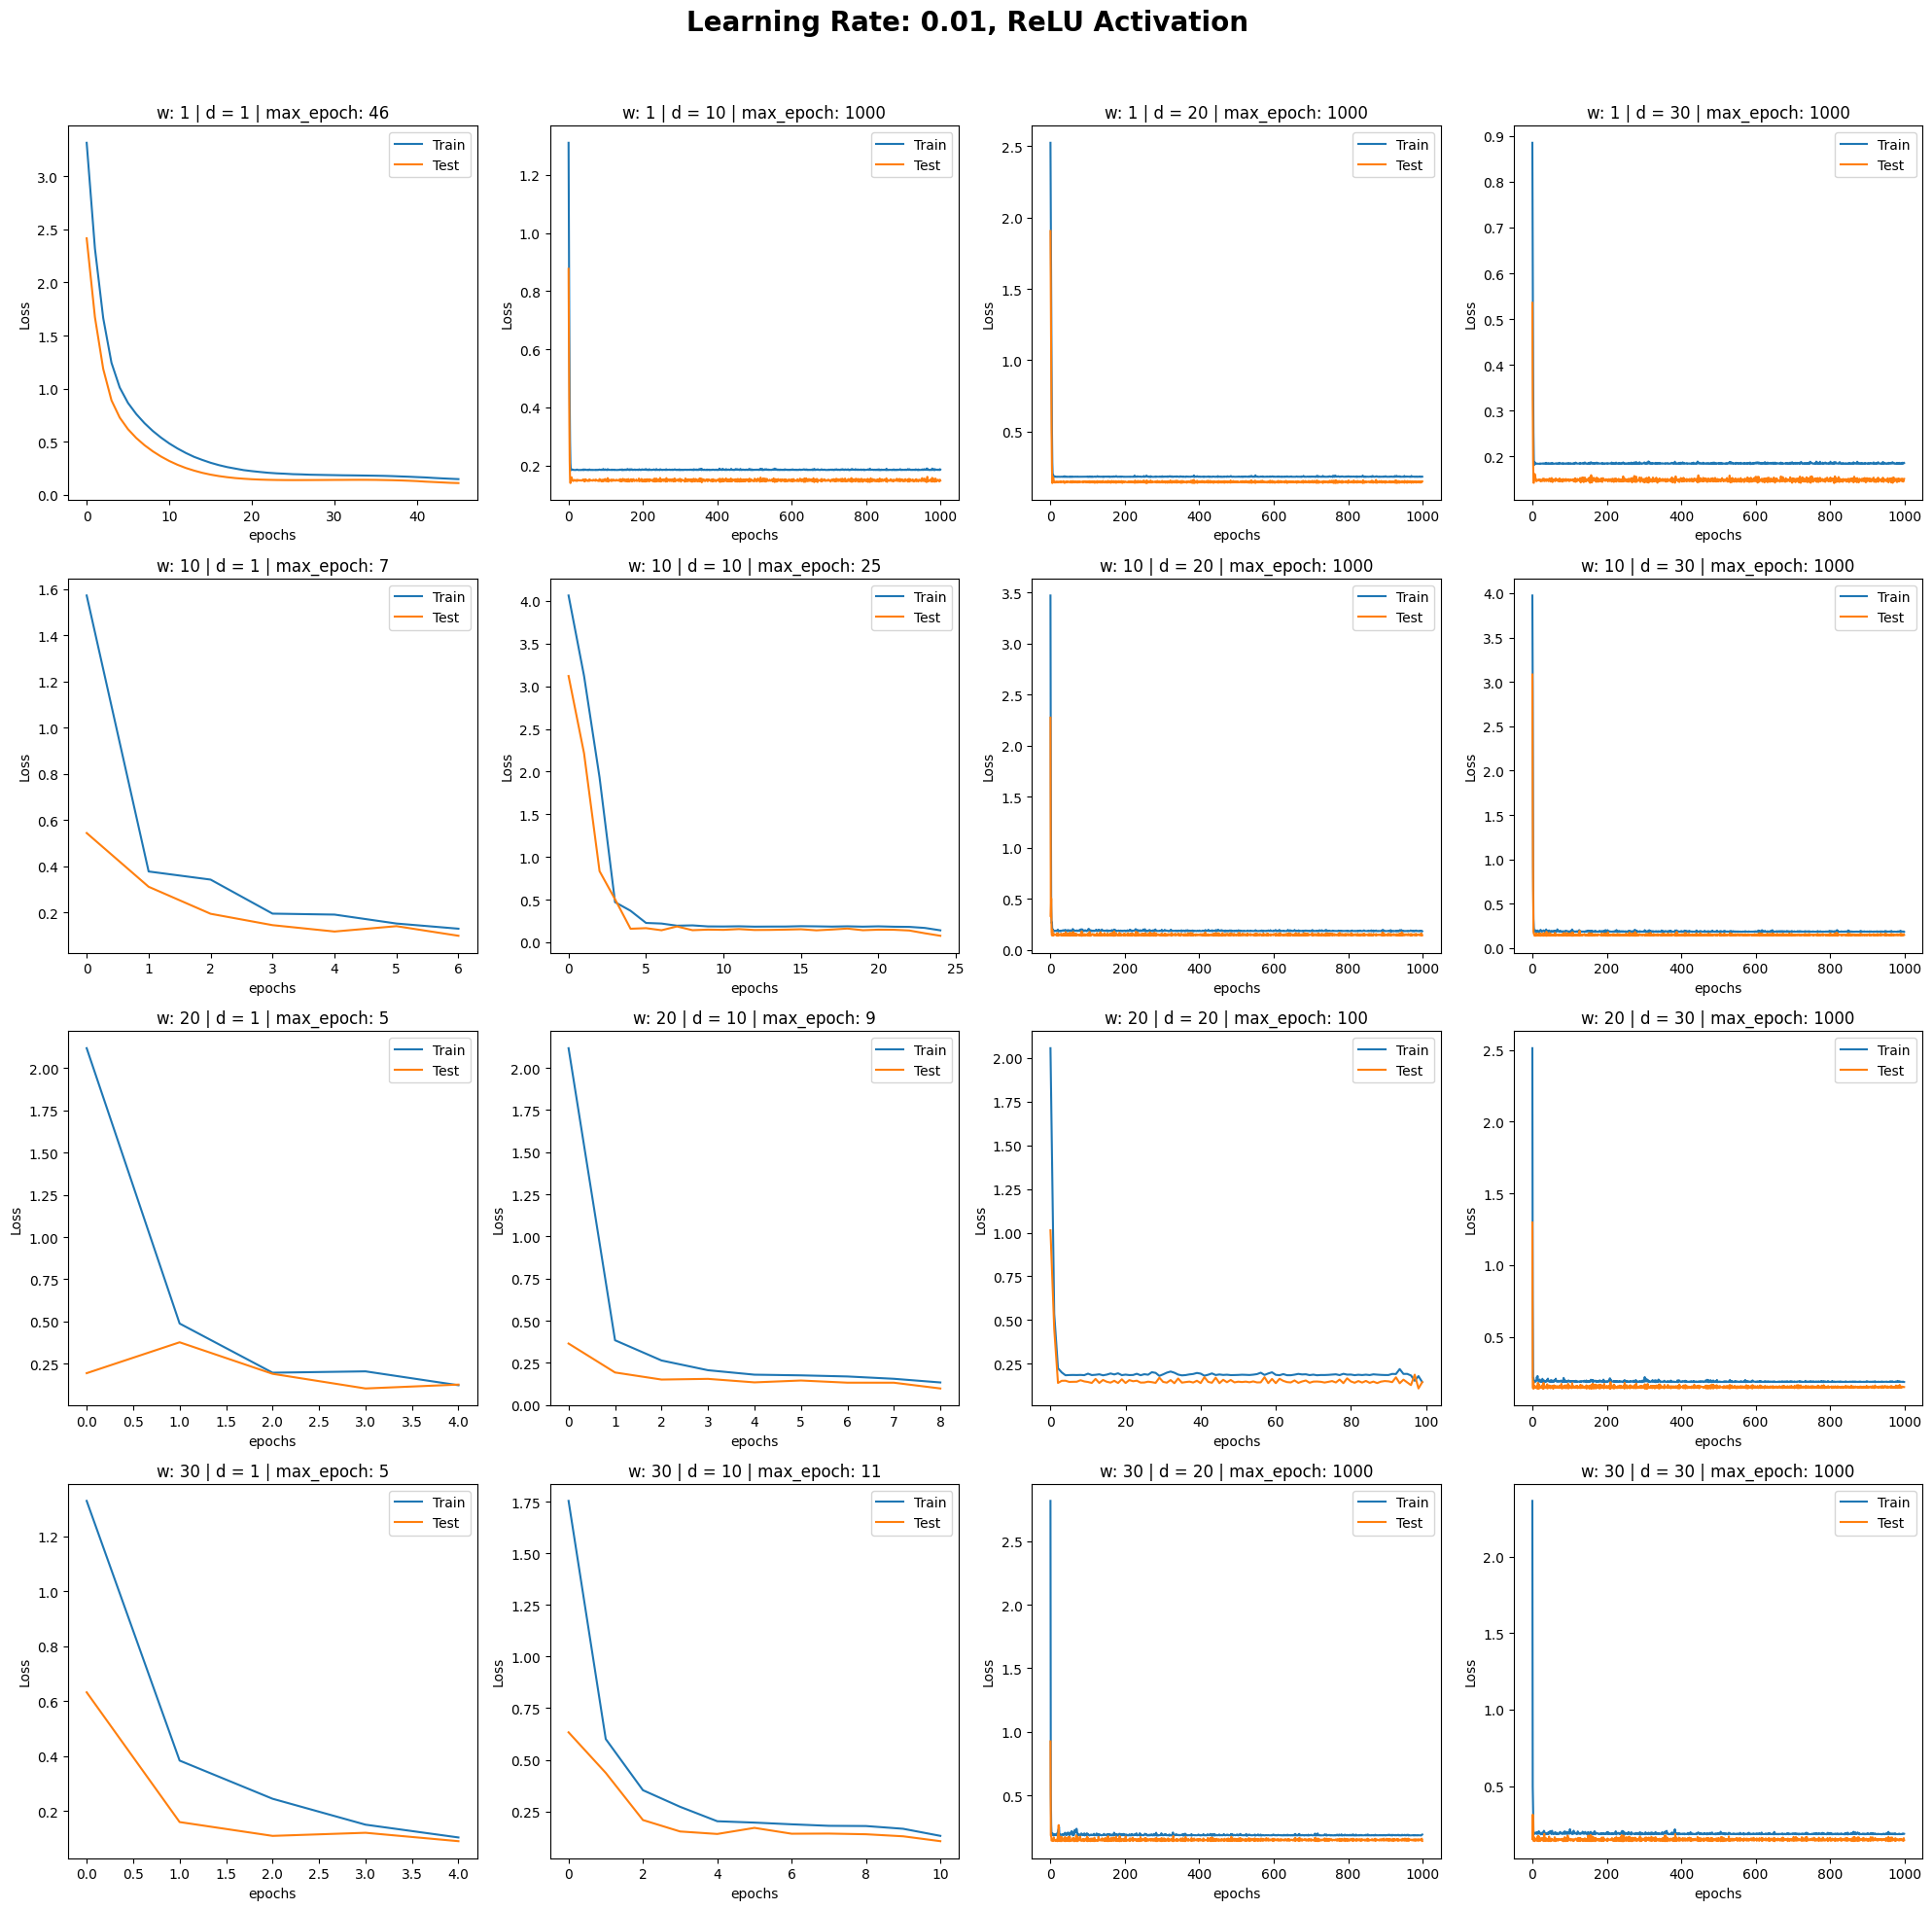

In [171]:
fig, axes = plt.subplots(len(widths), len(depths), figsize=(20, 20))

nn_enum = 0
for i, w in enumerate(widths):
    for j, d in enumerate(depths):
        log = logs[f"NN{nn_enum}"]
        axes[i][j].plot(log["train_loss"], label="Train")
        axes[i][j].plot(log["test_loss"], label="Test")
        axes[i][j].legend()
        nn_enum += 1

        axes[i][j].set(xlabel='epochs', ylabel='Loss')
        axes[i][j].set_title(f"w: {log['width']} | d = {log['Depth']} | max_epoch: {len(log['train_loss'])}")

fig.suptitle(
    f"Learning Rate: {lr}, ReLU Activation",
    fontsize=20,
    fontweight='bold'
)

plt.tight_layout(rect=[0, 0, 1, 0.96])



In [176]:
batch_sizes = [10, 30, 50, 70, 90, 100]
logs = {}
for bs in batch_sizes:
    logs[bs] = {"train_loss": [], "test_loss": []}
    train_dataloader = DataLoader(dataset = training_dataset, batch_size=bs, shuffle=True)
    test_dataloader = DataLoader(dataset = test_dataset, batch_size=bs, shuffle=False)

    logs[bs]["batch_size"] = bs
    model = LinearRegression(width=30, depth=10)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(epochs):
        epoch_loss_train= 0
        for x_batch, y_batch in train_dataloader:
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            epoch_loss_train+= loss.item()
            loss.backward()
            optimizer.step()
        
        epoch_loss_train /= len(train_dataloader)
        
        epoch_loss_test = 0
        with torch.no_grad():
            for x_batch_test, y_batch_test in test_dataloader:
                y_pred_test = model(x_batch_test)
                loss_test = loss_fn(y_pred_test, y_batch_test)
                epoch_loss_test += loss_test.item()
            epoch_loss_test /= len(test_dataloader)

        logs[bs]["train_loss"].append(epoch_loss_train)
        logs[bs]["test_loss"].append(epoch_loss_test)

        if epoch % 100 == 0:
            print(f"Epoch {epoch} | train loss = {epoch_loss_train:.4f} | test loss = {epoch_loss_test:.4f}")

        if (epoch_loss_train < epsilon) and (epoch_loss_test < epsilon): 
            print("converged")
            break

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([10, 2])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([30, 2])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([20, 2])) that is different to the input size (torch.Size([20, 1])). 

Epoch 0 | train loss = 2.5963 | test loss = 2.1671
converged
Epoch 0 | train loss = 3.2595 | test loss = 2.7837
converged
Epoch 0 | train loss = 3.8628 | test loss = 3.3991


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([50, 2])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([70, 2])) that is different to the input size (torch.Size([70, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([80, 2])) that is different to the input size (torch.Size([80, 1])). 

converged
Epoch 0 | train loss = 3.8315 | test loss = 3.6216
converged
Epoch 0 | train loss = 3.2898 | test loss = 2.8732
converged
Epoch 0 | train loss = 3.6618 | test loss = 3.2422
Epoch 100 | train loss = 0.1541 | test loss = 0.1175
converged


In [177]:
for bs in logs.keys():
    logs[bs]["tr_len"] = len(logs[bs]['train_loss'])
    logs[bs]["te_len"] = len(logs[bs]['test_loss'])
    del logs[bs]["train_loss"]
    del logs[bs]["test_loss"]

In [178]:
pd.DataFrame(logs)

,10,30,50,70,90,100
batch_size,10,30,50,70,90,100
tr_len,13,30,50,39,95,104
te_len,13,30,50,39,95,104


In [175]:
logs

{10: {'batch_size': 10, 'tr_len': 18, 'te_len': 18},
 30: {'batch_size': 30, 'tr_len': 29, 'te_len': 29},
 50: {'batch_size': 50, 'tr_len': 46, 'te_len': 46},
 70: {'batch_size': 70, 'tr_len': 32, 'te_len': 32},
 90: {'batch_size': 90, 'tr_len': 92, 'te_len': 92},
 100: {'batch_size': 100, 'tr_len': 62, 'te_len': 62}}